# OSM Change and Changeset Analyser
#### by Eva-Maria Klier

This python script is a supporting tool for downloading and analysing OSM Changesets.


In [215]:
#Imports
import requests
import pandas as pd
import pandasql as psql


## 1. Downloading OSM Changesets within a BoundingBox and TimeIntervall
In the following lines you can download all OSM Changesets in a specific BoundingBox (bbox) and TimeIntervall (t1 and t2).<br>
The bbox is written as min_lon,min_lat,max_lon,max_lat (W,S,E,N). <br>
With the TimeIntervall t1,t2 the output is all changesets that were closed after t1 and created before t2. Meaning, any OSM Changeset that was open in the TimeIntervall t1 to t2 is part of the output.

In [216]:
bbox = "8.3,48.9,8.5,49.1" #BoundingBox
t1 = "2021-01-01T00:00:00+00:0" #Upper bound of TimeInterval - closed after t1
t2 = "2021-01-03T00:00:00+00:0" #lower bound of the TimeInterval - created before t2

dflist = []
ele = 101
while (ele >= 100) :
    
    print(t1,t2)
    r = requests.get("https://api.openstreetmap.org/api/0.6/changesets?bbox={}&time={},{}".format(bbox, t1, t2))
    print(r.status_code) #200 means it works, 404 means there is a problem

    xml = r.text
    ele = xml.count("changeset id") 
    
    df = pd.read_xml(r.text) #locally saves the xml output as a dataframe
    
    dftag = pd.read_xml(r.text, xpath ="./changeset | ./changeset/tag") #reads all k=v pairs in a table
    idcount = 0
    dftag.fillna("nan",inplace=True)
   
    for index, row in dftag.iterrows() : #this for loop will read and insert the k=v in the dataframe
        if row['id'] != 'nan' :
            idcount+=1
            df.loc[idcount-1,'tag']=[{}] #creats a empty dictionary in the "tag" cell
        else :
            df.loc[idcount-1,'tag'][row['k']]=row['v'] #insert all k=v (in tag) as the newly created dictionary in the dataframe
    
    dflist.append(df) #puts the new dataframe in a list for dataframes
    
    t2 = df['created_at'].iloc[-1][0:-1]


result = pd.concat(dflist) #Combining all dataframes in the list
result = result[::-1] #turning the list upsidedown for chronical reading
result.reset_index(drop=True, inplace=True) #re-index the list

2021-01-01T00:00:00+00:0 2021-01-03T00:00:00+00:0
200
2021-01-01T00:00:00+00:0 2021-01-01T14:08:22
200


#### Export DataFrame as XML

In [217]:
result.to_xml('result.XML', index=False)

### Import and read XML

In [184]:
def yourXMLFile(path, itemname):
    dfimp = pd.read_xml(path) 
    
    dfimptag = pd.read_xml(path, xpath =f"./{itemname} | ./{itemname}/tag") 
    idcount = 0

    if 'k' in dfimptag.columns:
        dfimptag.fillna("nan",inplace=True)
        for index, row in dfimptag.iterrows() : 
            if row['id'] != 'nan' :
                idcount+=1
                dfimp.loc[idcount-1,'tag']=[{}] 
            else :
                dfimp.loc[idcount-1,'tag'][row['k']]=row['v']
    
    return dfimp

In [185]:
dfimp = yourXMLFile("test.xml", "changeset") # imput (Your XML File, name of the nodes e.g. changeset, item, row)

### 1.1 Queries with Pandas and PandaSQL
Please read this https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_sql.html for syntax questions.

In [208]:
countcol = dfimp.groupby('changes_count').count() #groups and counts values in column X
countcol

,id,created_at,open,comments_count,closed_at,min_lat,min_lon,max_lat,max_lon,uid,user,tag
changes_count,,,,,,,,,,,,
1,39,39,39,39,39,39,39,39,39,39,39,39
2,13,13,13,13,13,13,13,13,13,13,13,13
3,6,6,6,6,6,6,6,6,6,6,6,6
4,3,3,3,3,3,3,3,3,3,3,3,3
5,7,7,7,7,7,7,7,7,7,7,7,7
6,2,2,2,2,2,2,2,2,2,2,2,2
7,3,3,3,3,3,3,3,3,3,3,3,3
9,2,2,2,2,2,2,2,2,2,2,2,2
10,3,3,3,3,3,3,3,3,3,3,3,3


In [199]:
def pandaSQL (dataframe, sqlquery):
    subset = dataframe.iloc[:,:-1]
    sqlanswer = psql.sqldf(sqlquery)
    return sqlanswer

In [201]:
sqltest = pandaSQL(dfimp, "select count(changes_count), changes_count from subset group by changes_count") #dataframe you want to use, for sql query use always 'from subset'!!!
sqltest

,count(changes_count),changes_count
0,39,1
1,13,2
2,6,3
3,3,4
4,7,5
5,2,6
6,3,7
7,2,9
8,3,10
9,2,11


<AxesSubplot:xlabel='changes_count'>

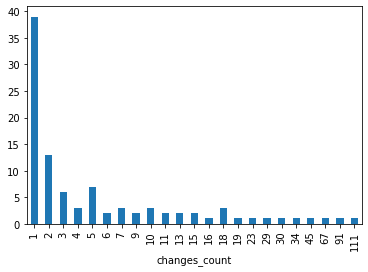

In [210]:
countcol['id'].plot.bar() #plots the countcol in a bar plot

### 1.2 Queries in 'tag'

In [160]:
def tagAnalysis(dataframe, key, value):
    filterlist = [] 

    for index, row in dataframe.iterrows() :
        if row.loc['tag'].get(key) == value:
            filterlist.append(index)
        
    return dataframe.loc[filterlist]

In [214]:
tagselect = tagAnalysis(dfimp,'source', 'survey') #dataframe/table you want to search in, 'key', 'value
tagselect

,id,created_at,open,comments_count,changes_count,closed_at,min_lat,min_lon,max_lat,max_lon,uid,user,tag
2,96788894,2021-01-01T22:02:35Z,False,0,4,2021-01-01T22:02:36Z,48.995329,8.402212,48.995513,8.402508,1704644,Radboss,"{'source': 'survey', 'created_by': 'JOSM/1.5 (..."
3,96788633,2021-01-01T21:51:23Z,False,0,3,2021-01-01T21:51:23Z,48.996840,8.406635,48.996980,8.406876,1704644,Radboss,"{'source': 'survey', 'created_by': 'JOSM/1.5 (..."
4,96788506,2021-01-01T21:47:28Z,False,0,2,2021-01-01T21:47:29Z,48.996454,8.407033,48.996631,8.407210,1704644,Radboss,"{'source': 'survey', 'created_by': 'JOSM/1.5 (..."
5,96788385,2021-01-01T21:42:58Z,False,0,1,2021-01-01T21:42:58Z,49.002133,8.408169,49.002133,8.408169,1704644,Radboss,"{'source': 'survey', 'created_by': 'JOSM/1.5 (..."
7,96787951,2021-01-01T21:25:58Z,False,0,1,2021-01-01T21:25:59Z,49.002778,8.408126,49.002778,8.408126,1704644,Radboss,"{'source': 'survey', 'created_by': 'JOSM/1.5 (..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,96764277,2021-01-01T10:25:31Z,False,0,2,2021-01-01T11:44:52Z,48.996379,8.358683,49.009338,8.490032,7342010,kuloe,"{'source': 'survey', 'StreetComplete:quest_typ..."
92,96764276,2021-01-01T10:25:30Z,False,0,2,2021-01-01T11:44:34Z,48.996379,8.358683,49.009338,8.490032,7342010,kuloe,"{'source': 'survey', 'StreetComplete:quest_typ..."
93,96764275,2021-01-01T10:25:29Z,False,0,1,2021-01-01T11:25:29Z,48.994764,8.486132,48.996424,8.492605,7342010,kuloe,"{'source': 'survey', 'StreetComplete:quest_typ..."
94,96764014,2021-01-01T10:17:48Z,False,0,7,2021-01-01T10:17:48Z,48.768377,8.491428,49.862126,12.570911,12169583,davidfaure_bot,"{'source': 'survey', 'comment': 'Fixing openin..."
